# Morphological Graph from Overture Maps with city2graph

This notebook demonstrates how to create **morphological graph** using `city2graph` and data from Overture Maps. Morphological graph provide a comprehensive graph representation of urban form that captures the relationships between public and private spaces in cities.

## What are Morphological Graphs?

Morphological graphs are heterogeneous graphs where:
- **Nodes** represent both public spaces (street segments) and private spaces (enclosed areas/tessellations)
- **Edges** capture three types of spatial relationships:
  - 🔴 **Private-to-private**: Adjacency between neighboring private spaces
  - 🔵 **Public-to-public**: Connectivity along street networks (dual graph representation)
  - 🟣 **Private-to-public**: Interface between private spaces and adjacent streets

## Workflow Overview

1. **Data Loading**: Import building footprints and street segments from Overture Maps
2. **Data Processing**: Clean and prepare spatial data for network creation
3. **Morphological Graph Generation**: Create tessellations and extract spatial relationships
4. **Graph Conversion**: Convert to PyTorch Geometric for machine learning applications
5. **Visualization**: Explore the resulting morphological graph

This approach enables advanced urban analytics including connectivity analysis, accessibility studies, and graph-based machine learning for urban form analysis.

## 1. Setup and Dependencies

In [1]:
# Core libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely import Point

# city2graph for morphological graph analysis
import city2graph

# Configure matplotlib for high-quality visualizations
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')

print("✅ Dependencies loaded successfully")
print(f"city2graph version: {city2graph.__version__}")
print(f"geopandas version: {gpd.__version__}")

✅ Dependencies loaded successfully
city2graph version: 0.1.1
geopandas version: 1.0.1


## 2. Loading Data from Overture Maps

We'll work with real urban data from Liverpool, UK, using Overture Maps which provides high-quality, open geospatial data including:
- **Building footprints**: Representing private/built spaces
- **Road segments**: Representing the street network
- **Connectors**: Intersection points in the road network

The data covers Liverpool city centre and demonstrates how city2graph can process real-world urban environments.

In [ ]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Liverpool city centre

bbox = [-3.090173, 53.355487, -2.917138, 53.465587]  # Liverpool city centre bounding box

city2graph.load_overture_data(
    area=bbox,
    types=["segment", "building", "connector"], 
    output_dir=".",
    prefix="liverpool_",
    save_to_file=True,
    return_data=False
)

print("Data loading configuration complete")
print("To download fresh data, uncomment the city2graph.load_overture_data() call above")

Data loading configuration complete
To download fresh data, uncomment the city2graph.load_overture_data() call above


In [3]:
# Load the downloaded GeoJSON files
buildings_gdf = gpd.read_file("liverpool_building.geojson")
segments_gdf = gpd.read_file("liverpool_segment.geojson") 
connectors_gdf = gpd.read_file("liverpool_connector.geojson")

# Convert to British National Grid (EPSG:27700) for accurate distance calculations
buildings_gdf = buildings_gdf.to_crs(epsg=27700)
segments_gdf = segments_gdf.to_crs(epsg=27700)
connectors_gdf = connectors_gdf.to_crs(epsg=27700)

print("✅ Data loaded successfully!")
print(f"📊 Dataset summary:")
print(f"   • Buildings: {len(buildings_gdf):,}")
print(f"   • Road segments: {len(segments_gdf):,}")
print(f"   • Connectors: {len(connectors_gdf):,}")
print(f"   • CRS: {buildings_gdf.crs}")

✅ Data loaded successfully!
📊 Dataset summary:
   • Buildings: 132,972
   • Road segments: 37,474
   • Connectors: 47,367
   • CRS: EPSG:27700


## 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [4]:
# Filter to keep only road segments (excluding pedestrian paths, railways, etc.)
segments_gdf = segments_gdf[segments_gdf["subtype"] == "road"].copy()

# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf = city2graph.process_overture_segments(
    segments_gdf=segments_gdf,
    get_barriers=True,
    connectors_gdf=connectors_gdf
)

print(f"✅ Processed {len(segments_gdf)} road segments")
print(f"📈 Barrier geometries created for tessellation")

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf["barrier_geometry"].geom_type.value_counts()
print(f"\n🔍 Barrier geometry types:")
for geom_type, count in geometry_types.items():
    print(f"   • {geom_type}: {count:,}")

✅ Processed 62116 road segments
📈 Barrier geometries created for tessellation

🔍 Barrier geometry types:
   • LineString: 61,184
   • MultiLineString: 521


## 4. Creating Morphological Graphs

Now we'll create the morphological graph - the core contribution of city2graph. This process:

<div align="center">
    <img src="../_static/morph_net_process.png" alt="Morphological Graph Process" width="800"/>
</div>

### The Process:

1. **Tessellation Creation**: Divide space into private areas using street segments as barriers
2. **Network Extraction**: Identify three types of spatial relationships:
   - **Private-to-private** (red): Adjacency between neighboring private spaces
   - **Public-to-public** (blue): Connectivity along street networks 
   - **Private-to-public** (purple): Interface between private spaces and streets

### Why Morphological Graphs?

Unlike traditional approaches that analyze street networks and buildings separately, morphological graphs provide a **unified representation** of urban space that:

- Captures the complete topology of public and private spaces
- Enables holistic urban analysis combining street accessibility and land use
- Provides a foundation for spatially-explicit graph machine learning
- Supports integration of diverse urban attributes (POIs, demographics, functions)

In [5]:
# Define center point for the analysis area (Liverpool city centre)
center_point = gpd.GeoSeries([Point(-2.9879004, 53.4062724)], crs='EPSG:4326').to_crs(epsg=27700)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print(f"📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

Removed 7 invalid geometries


🏗️  Creating morphological graph...


/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


✅ Morphological graph created successfully!
📊 Network summary:
   • Node types: ['private', 'public']
   • Edge types: [('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')]
   • Private spaces: 1,341
   • Public spaces: 777
   • ('private', 'touched_to', 'private'): 625 connections
   • ('public', 'connected_to', 'public'): 1,425 connections
   • ('private', 'faced_to', 'public'): 2,434 connections


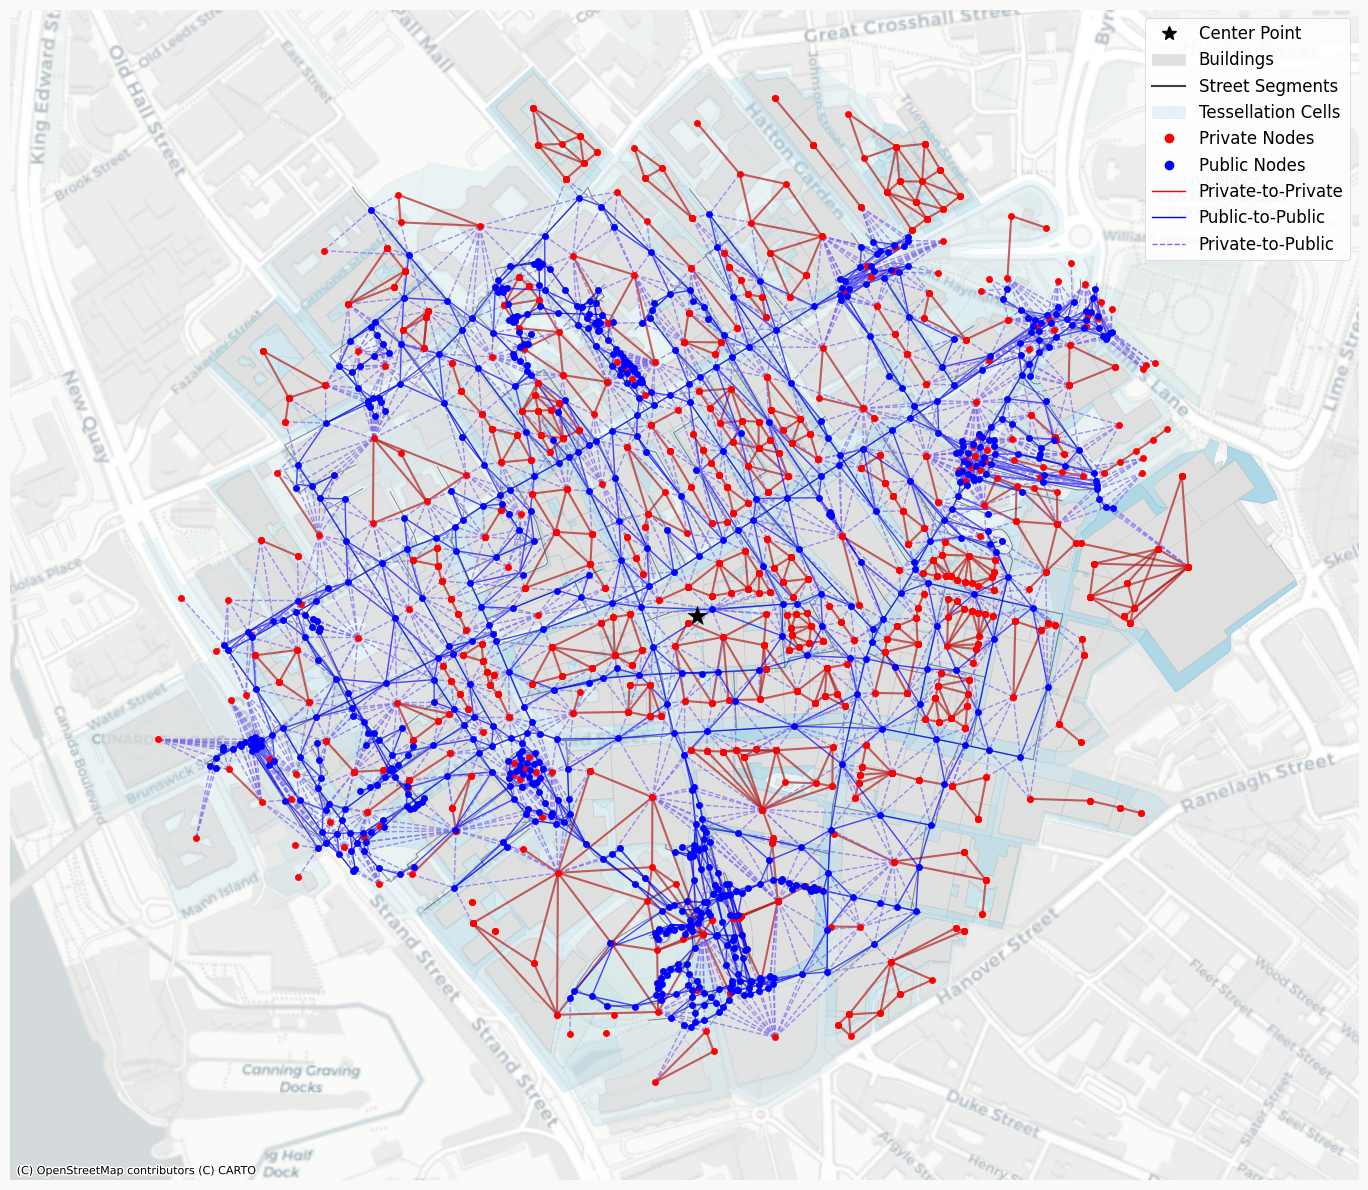

In [6]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right', 
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()

## 6. Converting to Graph Representations for Machine Learning

city2graph provides seamless conversion between spatial data and graph formats optimized for machine learning. We'll demonstrate conversion to PyTorch Geometric, enabling advanced graph neural network applications for urban analysis.

### Graph Format Support:
- **NetworkX**: For traditional graph analysis and algorithms
- **PyTorch Geometric**: For deep learning on graphs
- **GeoDataFrames**: For spatial analysis and visualization

This interoperability allows researchers to leverage the best tools for each analysis task.

In [7]:
# Check for PyTorch Geometric availability
import torch

try:
    import torch_geometric
    HAS_TORCH_GEOMETRIC = True
    print("✅ PyTorch Geometric successfully imported")
    print(f"   PyTorch version: {torch.__version__}")
    print(f"   PyTorch Geometric version: {torch_geometric.__version__}")
    print("🚀 Ready for graph representation learning!")
except ImportError:
    HAS_TORCH_GEOMETRIC = False
    print("⚠️  PyTorch Geometric not installed")
    print("   Install with: pip install torch-geometric")
    print("   Graph functionality will be limited to NetworkX")

✅ PyTorch Geometric successfully imported
   PyTorch version: 2.7.1
   PyTorch Geometric version: 2.6.1
🚀 Ready for graph representation learning!


### 6.1 Homogeneous Graph: Private Space Network

Let's start with a homogeneous graph focusing on private spaces (tessellation cells) and their adjacency relationships. This represents the spatial structure of plots and parcels in the urban environment.

In [8]:
# Compute spatial features for private spaces (tessellation cells)
morpho_nodes["private"]["area"] = morpho_nodes["private"].geometry.area
morpho_nodes["private"]["perimeter"] = morpho_nodes["private"].geometry.length
morpho_nodes["private"]["compactness"] = (
    4 * np.pi * morpho_nodes["private"]["area"] / (morpho_nodes["private"]["perimeter"] ** 2)
)

print("📊 Computed spatial features for private spaces:")
feature_stats = morpho_nodes["private"][['area', 'perimeter', 'compactness']].describe()
print(feature_stats.round(2))

# Set proper index names for graph conversion
morpho_nodes["private"].index.name = "tess_id"
morpho_edges[('private', 'touched_to', 'private')].index.names = ['from_private_id', 'to_private_id']

print("\n✅ Features computed and indices configured")

📊 Computed spatial features for private spaces:
           area  perimeter  compactness
count   1341.00    1341.00      1341.00
mean    1388.65     141.24         0.61
std     2801.76     110.94         0.15
min        0.00       0.00         0.03
25%      286.56      75.55         0.53
50%      564.34     107.79         0.64
75%     1294.72     162.18         0.73
max    23421.96     791.12         0.99

✅ Features computed and indices configured


In [9]:
if HAS_TORCH_GEOMETRIC:
    # Create homogeneous graph of private spaces
    private_graph = city2graph.gdf_to_pyg(
        nodes=morpho_nodes["private"],
        edges=morpho_edges[('private', 'touched_to', 'private')],
        node_feature_cols=['area', 'perimeter', 'compactness'],
        edge_feature_cols=None
    )
    
    print("🎯 Created homogeneous graph:")
    print(f"   • Nodes: {private_graph.num_nodes:,}")
    print(f"   • Edges: {private_graph.num_edges:,}")
    print(f"   • Node features: {private_graph.x.shape[1]} dimensions")
    print(f"   • Feature tensor shape: {private_graph.x.shape}")
    print("\n✅ Ready for graph neural network training!")
    
else:
    print("⚠️ Skipping PyTorch Geometric conversion (not installed)")
    private_graph = None

🎯 Created homogeneous graph:
   • Nodes: 1,341
   • Edges: 625
   • Node features: 3 dimensions
   • Feature tensor shape: torch.Size([1341, 3])

✅ Ready for graph neural network training!


#### Test Graph Conversions

Let's test the round-trip conversions between different graph formats to ensure data integrity:

### 6.2 Heterogeneous Graph: Complete Morphological Graph

Now let's create a heterogeneous graph that captures the full morphological graph with all node and edge types. This provides the complete representation for advanced urban analysis.

In [11]:
# Define center point for the analysis area (Liverpool city centre)
center_point = gpd.GeoSeries([Point(-2.9879004, 53.4062724)], crs='EPSG:4326').to_crs(epsg=27700)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print(f"📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

Removed 7 invalid geometries


🏗️  Creating morphological graph...


/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


✅ Morphological graph created successfully!
📊 Network summary:
   • Node types: ['private', 'public']
   • Edge types: [('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')]
   • Private spaces: 1,341
   • Public spaces: 777
   • ('private', 'touched_to', 'private'): 625 connections
   • ('public', 'connected_to', 'public'): 1,425 connections
   • ('private', 'faced_to', 'public'): 2,434 connections


In [12]:
# Compute features for public spaces (street segments)
morpho_nodes["public"]["length"] = morpho_nodes["public"].geometry.length

print("📊 Computed spatial features for public spaces:")
print(f"   • Street length statistics:")
length_stats = morpho_nodes["public"]["length"].describe()
print(f"     - Mean: {length_stats['mean']:.1f}m")
print(f"     - Median: {length_stats['50%']:.1f}m") 
print(f"     - Range: {length_stats['min']:.1f}m - {length_stats['max']:.1f}m")

print(f"\n✅ Features ready for heterogeneous graph creation")

📊 Computed spatial features for public spaces:
   • Street length statistics:
     - Mean: 24.6m
     - Median: 14.8m
     - Range: 0.8m - 153.9m

✅ Features ready for heterogeneous graph creation


In [13]:
if HAS_TORCH_GEOMETRIC:
    # Create heterogeneous graph with all morphological relationships
    hetero_graph = city2graph.gdf_to_pyg(
        morpho_nodes,
        morpho_edges,
        node_feature_cols={
            "private": ['area', 'perimeter', 'compactness'],
            "public": ['length']
        }
    )
    
    print("🌐 Created heterogeneous morphological graph:")
    print(f"   📊 Node types and counts:")
    for node_type in hetero_graph.node_types:
        num_nodes = hetero_graph[node_type].x.shape[0]
        num_features = hetero_graph[node_type].x.shape[1]
        print(f"     • {node_type}: {num_nodes:,} nodes, {num_features} features")
    
    print(f"   🔗 Edge types and counts:")
    for edge_type in hetero_graph.edge_types:
        num_edges = hetero_graph[edge_type].edge_index.shape[1]
        print(f"     • {edge_type}: {num_edges:,} edges")
    
    print("\n✅ Complete morphological graph ready for heterogeneous GNN training!")
    
else:
    print("⚠️ Skipping PyTorch Geometric conversion (not installed)")
    hetero_graph = None

🌐 Created heterogeneous morphological graph:
   📊 Node types and counts:
     • private: 1,341 nodes, 0 features
     • public: 777 nodes, 1 features
   🔗 Edge types and counts:
     • ('private', 'touched_to', 'private'): 625 edges
     • ('public', 'connected_to', 'public'): 0 edges
     • ('private', 'faced_to', 'public'): 2,434 edges

✅ Complete morphological graph ready for heterogeneous GNN training!


### 6.3 NetworkX Integration

city2graph provides seamless conversion to NetworkX for traditional graph analysis and algorithms. This enables access to the rich ecosystem of graph analysis tools.

In [14]:
morpho_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']},)

# Convert morphological graph to NetworkX for traditional graph analysis
G_morpho = city2graph.gdf_to_nx(morpho_nodes, morpho_edges)

print("🔗 Converted to NetworkX:")
print(f"   • Total nodes: {G_morpho.number_of_nodes():,}")
print(f"   • Total edges: {G_morpho.number_of_edges():,}")
print(f"   • Graph type: {'Directed' if G_morpho.is_directed() else 'Undirected'}")

# Check if it's a heterogeneous graph
has_node_types = any('node_type' in data for _, data in G_morpho.nodes(data=True))
print(f"   • Heterogeneous: {'Yes' if has_node_types else 'No'}")

if has_node_types:
    # Count nodes by type
    from collections import Counter
    node_types = [data.get('node_type', 'unknown') for _, data in G_morpho.nodes(data=True)]
    type_counts = Counter(node_types)
    print(f"   • Node type distribution:")
    for node_type, count in type_counts.items():
        print(f"     - {node_type}: {count:,}")

print("\n✅ Ready for NetworkX graph analysis algorithms!")

Could not find nodes for 1425 edges of type ('public', 'connected_to', 'public')


🔗 Converted to NetworkX:
   • Total nodes: 2,118
   • Total edges: 3,059
   • Graph type: Undirected
   • Heterogeneous: Yes
   • Node type distribution:
     - private: 1,341
     - public: 777

✅ Ready for NetworkX graph analysis algorithms!


## 7. Summary
Congratulations! You've successfully created morphological graphs from Overture Maps data using city2graph. This workflow provides:

### What We've Accomplished:
✅ **Data Integration**: Combined building footprints and street networks from Overture Maps  
✅ **Morphological Analysis**: Created tessellations representing private urban spaces  
✅ **Network Extraction**: Identified three types of spatial relationships  
✅ **Graph Conversion**: Generated both homogeneous and heterogeneous graph representations  
✅ **Machine Learning Ready**: Prepared data for PyTorch Geometric and NetworkX analysis  

### Applications Enabled:
- **Urban Connectivity Analysis**: Study how private and public spaces connect
- **Accessibility Research**: Measure spatial accessibility across urban areas  
- **Graph Neural Networks**: Apply deep learning to urban form analysis
- **Comparative Studies**: Analyze different cities using standardized representations
- **Planning Support**: Inform urban design with data-driven insights

### Next Steps:
1. **Add Urban Attributes**: Enrich nodes with POI data, demographics, or land use
2. **Multi-Scale Analysis**: Apply to different spatial scales (neighborhood to metropolitan)
3. **Temporal Studies**: Track urban evolution over time
4. **Machine Learning**: Train GNNs for prediction tasks (property values, accessibility, etc.)
5. **Cross-City Comparison**: Apply the same workflow to other cities

The morphological graph provides a foundation for sophisticated urban analysis that bridges traditional GIS approaches with modern graph machine learning techniques.

In [15]:
if HAS_TORCH_GEOMETRIC:
    import os
    import torch
    from torch_geometric.data import InMemoryDataset
    
    class MorphoGraphDataset(InMemoryDataset):
        """A PyTorch Geometric dataset for morphological graphs."""
        
        def __init__(self, root, transform=None, pre_transform=None):
            super().__init__(root, transform, pre_transform)
            if os.path.exists(self.processed_paths[0]):
                self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        
        @property
        def raw_file_names(self):
            return []
    
        @property
        def processed_file_names(self):
            return ['morpho_graph.pt']
        
        def download(self):
            # No download needed
            pass
            
        def process(self):
            # Use the existing morpho_graph as our single graph sample
            data_list = [hetero_graph]
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
    
    # Create and save the dataset
    os.makedirs('./morpho_graph_dataset/processed', exist_ok=True)
    
    try:
        dataset = MorphoGraphDataset(root='./morpho_graph_dataset')
        print(f"💾 Dataset created and saved with {len(dataset)} graph(s)")
        print(f"   📁 Saved to: ./morpho_graph_dataset/")
        print("✅ Ready for future machine learning experiments!")
    except Exception as e:
        print(f"ℹ️  Dataset creation skipped: {e}")
        
else:
    print("ℹ️  Dataset creation skipped (PyTorch Geometric not available or no hetero_graph)")

print("\n🎉 Morphological graph analysis complete!")

💾 Dataset created and saved with 1 graph(s)
   📁 Saved to: ./morpho_graph_dataset/
✅ Ready for future machine learning experiments!

🎉 Morphological graph analysis complete!


## 8. Additional Resources

### Documentation and Examples:
- **city2graph Documentation**: [Full API reference and tutorials](https://city2graph.readthedocs.io/)
- **Overture Maps**: [Open geospatial data platform](https://overturemaps.org/)
- **PyTorch Geometric**: [Graph deep learning framework](https://pytorch-geometric.readthedocs.io/)

### Key Functions Used:
- `city2graph.load_overture_data()`: Download data from Overture Maps
- `city2graph.process_overture_segments()`: Clean and process street networks  
- `city2graph.morphological_graph()`: Create morphological graphs
- `city2graph.gdf_to_pyg()`: Convert to PyTorch Geometric format
- `city2graph.gdf_to_nx()`: Convert to NetworkX format